# UMAP vs t-SNE Visualization and Embedding

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt.pyll.base import scope

import mag
from mag.experiment import Experiment
from mag import summarize


from speech2phone.preprocessing import get_TIMIT, get_phones
from speech2phone.preprocessing.filters import mel

np.set_printoptions(precision=3)

In [8]:
X_toy, y_toy = get_TIMIT(dataset='toy', preprocessor=mel, TIMIT_root='../TIMIT/TIMIT')
# X_toy, y_toy = load_digits(return_X_y=True)

Loading toy/mel set from cache... done.


In [34]:
embedding_umap = umap.UMAP().fit_transform(X_toy, y_toy)
embedding_tsne = TSNE(n_components=2).fit_transform(X_toy)
embedding_pca = PCA(n_components=2).fit_transform(X_toy)
embedding_nmf = 

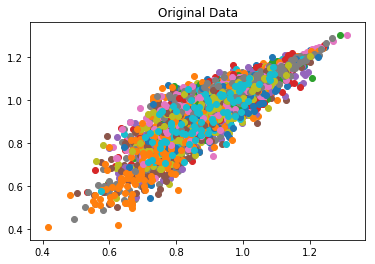

In [9]:
fig, ax = plt.subplots(1)
for i in range(y_toy.max()):
    ax.scatter(X_toy[y_toy == i,0], X_toy[y_toy == i,1])
ax.set_title("Original Data")
plt.savefig('../visualizations/no_embedding.png')

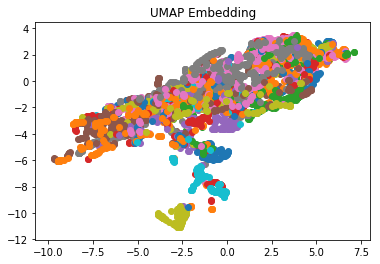

In [45]:
fig, ax = plt.subplots(1)
for i in range(y_toy.max()):
    ax.scatter(embedding[y_toy == i,0], embedding[y_toy == i,1])
ax.set_title("UMAP Embedding")
plt.savefig('../visualizations/umap_embedding.png')

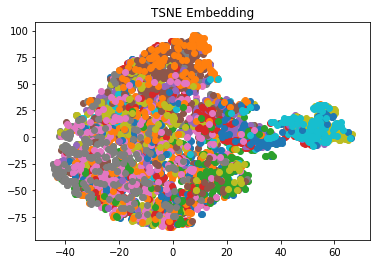

In [46]:
for i in range(y_toy.max()):
    plt.scatter(embedding_tsne[y_toy == i,0], embedding_tsne[y_toy == i,1])
plt.title("TSNE Embedding")
plt.savefig('../visualizations/tsne_embedding.png')

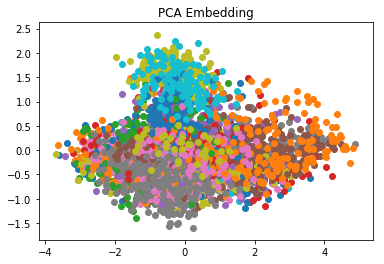

In [47]:
for i in range(y_toy.max()):
    plt.scatter(embedding_pca[y_toy == i,0], embedding_pca[y_toy == i,1])
plt.title("PCA Embedding")
plt.savefig('../visualizations/pca_embedding.png')

In [1]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng,
                                      normalize_components=True),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# #############################################################################
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    ('Dictionary learning - positive code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_code=True),
     True),
    ('Dictionary learning - positive dictionary & code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True,
                                                  positive_code=True),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components],
             cmap=plt.cm.RdBu)

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], cmap=plt.cm.RdBu)

plt.show()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/jarednielsen/scikit_learn_data
Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.117s
Extracting the top 6 Non-negative components - NMF...
done in 0.296s
Extracting the top 6 Independent components - FastICA...
done in 0.184s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 0.702s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.494s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.092s
Extracting the top 6 Factor Analysis components - FA...
done in 0.078s


/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 200x226 with 1 Axes>

<Figure size 600x452 with 6 Axes>

Extracting the top 6 Dictionary learning...
done in 0.452s
Extracting the top 6 Dictionary learning - positive dictionary...
done in 0.521s
Extracting the top 6 Dictionary learning - positive code...
done in 0.383s
Extracting the top 6 Dictionary learning - positive dictionary & code...
done in 0.251s


<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>

<Figure size 600x452 with 6 Axes>